# Faces in the wild
 * Original paper (database): https://people.cs.umass.edu/~elm/papers/lfw.pdf
 * https://www.researchgate.net/publication/305552545_Labeled_Faces_in_the_Wild_A_Survey, https://people.cs.umass.edu/~elm/papers/LFW_survey.pdf
 


In [169]:
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_lfw_pairs

lfw_people = fetch_lfw_people(resize=1.0)
lfw_pairs_train = fetch_lfw_pairs(subset='train',resize=1.0)
lfw_pairs_test = fetch_lfw_pairs(subset='test',resize=1.0)
lfw_pairs_10_folds = fetch_lfw_pairs(subset='10_folds',resize=1.0)

AJ Cook
AJ Lamas
Aaron Eckhart
Aaron Guiel

lfw_people.images.shape=(13233, 125, 94)
lfw_pairs_train.pairs.shape=(2200, 2, 125, 94)


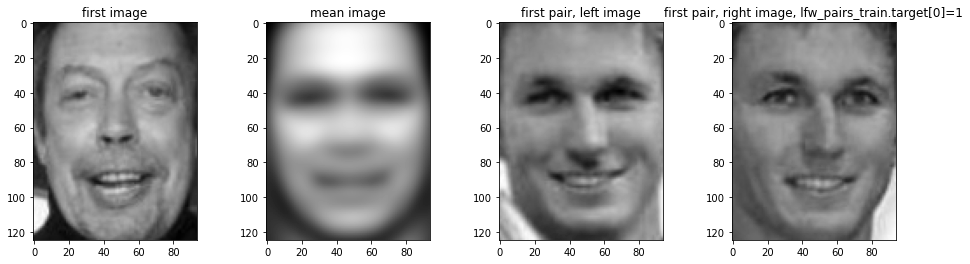

In [170]:
from pylab import *
for name in lfw_people.target_names[0:4]:
    print(name)
print("")
print(f"{lfw_people.images.shape=}")
print(f"{lfw_pairs_train.pairs.shape=}")

figure(figsize=[16,4])
subplot(1,4,1)
title("first image")
A = squeeze(lfw_people.images[0,:,:])
imshow(A, cm.gray)
subplot(1,4,2)
title("mean image")
imshow(mean(lfw_people.images, axis=0), cm.gray)
subplot(1,4,3)
title("first pair, left image")
imshow(lfw_pairs_train.pairs[0,0,:,:], cm.gray)
subplot(1,4,4)
title(f"first pair, right image, {lfw_pairs_train.target[0]=}")
imshow(lfw_pairs_train.pairs[0,1,:,:], cm.gray);

(n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient) ndarray: fd.shape=(9, 6, 5, 5, 8)
image size prod(A.shape)=11750 vs. feature size prod(fd.shape)=10800


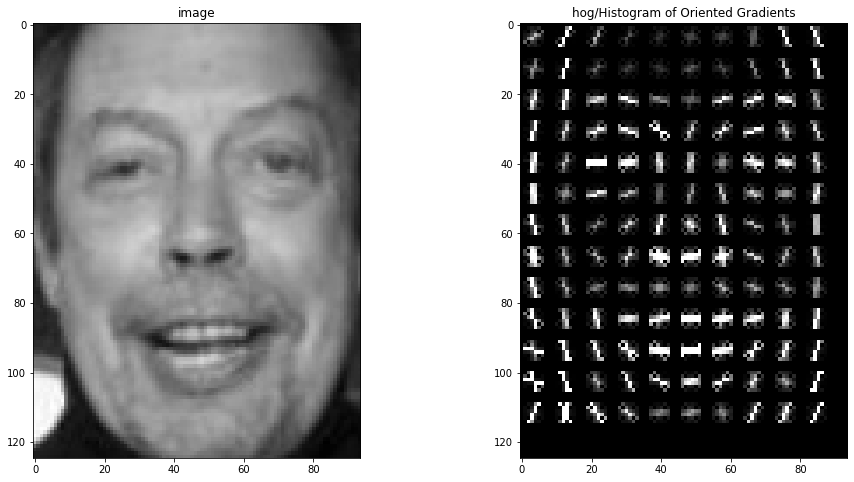

In [182]:
from skimage.feature import hog
from skimage import data, exposure

cellsize = 9
blocksize = 5

fd, hog_image = hog(A, orientations=8, pixels_per_cell=(cellsize, cellsize),
                    cells_per_block=(blocksize, blocksize), visualize=True, feature_vector=False)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

figure(figsize=[16,8])
subplot(1,2,1)
imshow(A, cm.gray)
title("image")

subplot(1,2,2)
imshow(hog_image_rescaled, cmap=plt.cm.gray)
title('hog/Histogram of Oriented Gradients')

print(f"(n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient) ndarray: {fd.shape=}")
print(f"image size {prod(A.shape)=} vs. feature size {prod(fd.shape)=}")

feature1size = prod(fd.shape)

In [183]:
def transform_data(D):
    data = D.pairs
    n = data.shape[0]
    tdata = None
    for k in range(n):
        fd1 = hog(squeeze(data[k,0,:,:]), orientations=10, pixels_per_cell=(cellsize, cellsize),
                 cells_per_block=(blocksize, blocksize), feature_vector=True)
        fd2 = hog(squeeze(data[k,1,:,:]), orientations=10, pixels_per_cell=(cellsize, cellsize),
                 cells_per_block=(blocksize, blocksize), feature_vector=True)
        if tdata is None:
            feature1size = len(fd1)
            tdata = zeros((n,feature1size*2))
        tdata[k,:] = concatenate((fd1,fd2))
    return tdata, D.target

In [173]:
def transform_data(D):
    data = D.pairs
    n = data.shape[0]
    tdata = None
    for k in range(n):
        fd1 = data[k,0,:,:].flatten()
        fd2 = data[k,1,:,:].flatten()
        if tdata is None:
            feature1size = len(fd1)
            tdata = zeros((n,feature1size*2))
        tdata[k,:] = concatenate((fd1,fd2))
    return tdata, D.target

In [184]:
X_train, y_train = transform_data(lfw_pairs_train)
print(f"{X_train.shape=}, {y_train.shape=}")

X_test, y_test = transform_data(lfw_pairs_test)
print(f"{X_test.shape=}, {y_test.shape=}")

X_train.shape=(2200, 27000), y_train.shape=(2200,)
X_test.shape=(1000, 27000), y_test.shape=(1000,)


In [185]:
from sklearn.ensemble import RandomForestClassifier
c = RandomForestClassifier(random_state=0, n_estimators=100, ccp_alpha=0.002)
c.fit(X_train,y_train)

yself = c.predict(X_train)
print(f"accuracy: {100*sum(yself==y_train)/len(yself)}% correct on training set")

yself = c.predict(X_test)
print(f"accuracy: {100*sum(yself==y_test)/len(yself)}% correct on test set")

accuracy: 100.0% correct on training set
accuracy: 54.8% correct on test set
